# Grid and Feature Contribution

This document shows the procedure of grid search and feature contribution investigation. 

In [1]:
from __future__ import division
import pandas as pd
import numpy as np 
import matplotlib.pylab as plt
from code.organize import *
from code.roughEDA import *
from code.survey_processor_full import *
from code.model_vis import *

from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix,roc_curve
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA

from treeinterpreter import treeinterpreter as ti
import matplotlib.cm as cm
import cPickle as pickle
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
sv = survey('data/survey2/')

In [3]:
sv.num_processor()

In [4]:
df = sv.fin_data

In [5]:
dfc = df.copy()
dfc['educom'] = (dfc.paeduc+dfc.maeduc+dfc.speduc)/3        
dfc.drop(['paeduc','maeduc','speduc'], axis =1, inplace=True)
y = dfc.pop('employed').values
X = dfc.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=90)

### 1. Fit random forest model

In [6]:
rf = RandomForestClassifier(n_jobs=-1,random_state=0)
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

#### Take first 30 important features to model

In [7]:
f30 = rf.feature_importances_.argsort()[::-1][:30]
rf_redu = RandomForestClassifier(n_jobs=-1,random_state=0)
slct=dfc.columns[f30]   #selected features
X = dfc[slct].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=90)

In [8]:
rf_redu.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

## 2. Grid search

In [9]:
#1st round
# rf_grid = {'max_depth': [3, None], 
#                       'max_features': ['sqrt', 'log2', None],
#                       'min_samples_split': [1, 2, 4],
#                       'min_samples_leaf': [1, 2, 4],
#                       'bootstrap': [True, False],
#                       'n_estimators': [10, 20, 40],
#                       'random_state': [1]}

#2nd
rf_grid = {'max_depth': [None], 
           'criterion':['gini','entropy'],
                      'max_features': ['log2', None],
                      'min_samples_split': [1],
                      'min_samples_leaf': [2],
                      'bootstrap': [True, False],
                      'n_estimators': [30, 40,80],
                      'random_state': [1]}

#3rd 
rf_grid = {'max_depth': [None], 
           'criterion':['gini'],
                      'max_features': ['log2',None],
                      'min_samples_split': [1],
                      'min_samples_leaf': [2],
                      'bootstrap': [False],
                      'n_estimators': [60,80,100],
                      'random_state': [1]}
#last round
rf_grid = {'max_depth': [None], 
           'criterion':['gini'],
                      'max_features': ['log2',None],
                      'min_samples_split': [1],
                      'min_samples_leaf': [2],
                      'bootstrap': [False],
                      'n_estimators': [230,250,300],
                      'random_state': [1]}

In [10]:
rf_gridsearch = GridSearchCV(RandomForestClassifier(),
                             rf_grid,
                             n_jobs=-1,
                             verbose=True,
                             scoring='roc_auc')

In [11]:
rf_gridsearch.fit(X_train,y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:   23.2s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [230, 250, 300], 'min_samples_split': [1], 'random_state': [1], 'criterion': ['gini'], 'max_features': ['log2', None], 'bootstrap': [False], 'max_depth': [None], 'min_samples_leaf': [2]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc',
       verbose=True)

In [12]:
rf_gridsearch.best_params_

{'bootstrap': False,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'log2',
 'min_samples_leaf': 2,
 'min_samples_split': 1,
 'n_estimators': 300,
 'random_state': 1}

In [13]:
best_rf = rf_gridsearch.best_estimator_

roc_auc_score : 0.818305210155


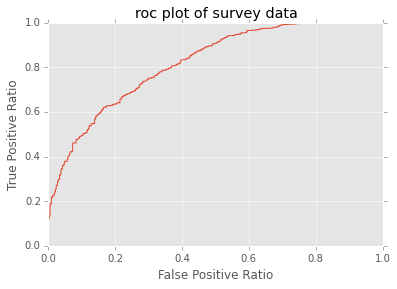

In [14]:
plot_roc(best_rf,X_test,y_test)

### 3.  Tree Interpreter and Feature Contribution

In [15]:
prediction, bias, contributions = ti.predict(best_rf, X)

#### make feature contribution data frame

In [16]:
fc_df = pd.DataFrame(contributions[:,:,1], columns=slct)

In [17]:
fc_df['predict'] = best_rf.predict(X)    # predicted result

In [18]:
fc_df['employed'] = y                   # true result

In [19]:
fc_df['correct'] = fc_df.predict == fc_df.employed      # check if the prediction is correct

In [20]:
fc_df.drop('predict',axis =1, inplace=True)               #subset correct instances

## 4. Clustering Feature Contribution Matrix

* pca
* kmeans on principle components

### PCA

In [21]:
fc_f_pca = fc_df.drop(['employed','correct'],axis =1)       #only pass feature columns to pca

In [22]:
pca = PCA(n_components= 10)
pca.fit(fc_f_pca.values)

PCA(copy=True, n_components=10, whiten=False)

In [23]:
np.cumsum(pca.explained_variance_ratio_),pca.explained_variance_ratio_

(array([ 0.28966923,  0.4192104 ,  0.52313406,  0.58592309,  0.64375447,
         0.68285598,  0.71732429,  0.7477722 ,  0.77376263,  0.79738463]),
 array([ 0.28966923,  0.12954117,  0.10392366,  0.06278902,  0.05783138,
         0.03910151,  0.03446832,  0.03044791,  0.02599043,  0.023622  ]))

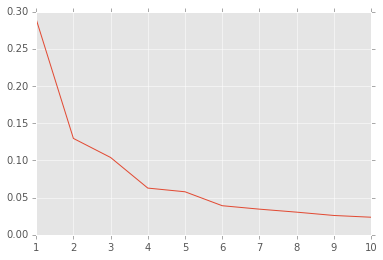

In [24]:
plt.plot(range(1,11),pca.explained_variance_ratio_)

** Three principle components will be fine **

In [25]:
pca = PCA(n_components=3)
fc_pca = pca.fit_transform(fc_f_pca.values)

### Kmeans

To determine which k for kmeans. I wrote a function to check kmeans cluster performance. 

1. Take a range of Ks and make a for loop

2. In each loop：
  * Generate k clusters using kmeans. concatinate cluster id to 'employed' and 'correct' columns, as a new data frame.
  * Group data frame by cluster id, calcuate employed rate and correct rate by taking means
  * If the employed rate is higher than 0.7 or lower than 0.3, then we can say this cluster successfull group employed or unemployed population, so this cluster yields pure population.
  * If the correct rate is higher than 0.7, we can say this cluter has high accuracy.
  * The clusters with pure population and meantime with high accuracy are ones we want. 
  * Therefore, the percentage of good clusters is calculated.
  * Print employed and correct rate of each good cluster, as well as the good cluster ratio.
  
3. plot total number of k against good cluster ratio

4 clusters
         employed   correct
cluster                    
0        0.330241  0.912801
1        0.921673  0.925679
2        0.019211  0.980789
3        0.870317  0.873199
---
4 out of 4 clusters split the target ideally. Good cluster rate: 1.0
********************
5 clusters
         employed   correct
cluster                    
0        0.920518  0.924214
1        0.018219  0.981781
2        0.889313  0.896947
3        0.076712  0.934247
4        0.871014  0.872464
---
5 out of 5 clusters split the target ideally. Good cluster rate: 1.0
********************
6 clusters
         employed   correct
cluster                    
0        0.067839  0.937186
1        0.058480  0.961988
2        0.927992  0.928469
3        0.077778  0.933333
4        0.895210  0.896707
5        0.889313  0.896947
---
6 out of 6 clusters split the target ideally. Good cluster rate: 1.0
********************
7 clusters
         employed   correct
cluster                    
0        0.985832  0.985832
1 

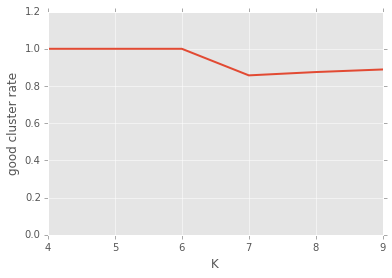

In [26]:
km_emp_mean(fc_pca,10,fc_df.employed,fc_df.correct)

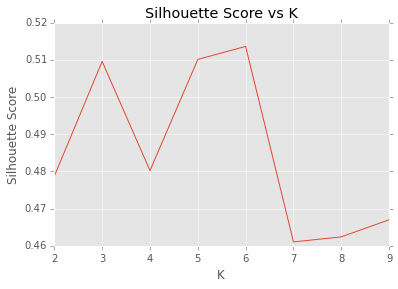

In [27]:
plot_silhouette(fc_pca,10)

('For n_clusters =', 6, 'The average silhouette_score is :', 0.51357348835786176)


/Users/yleng/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


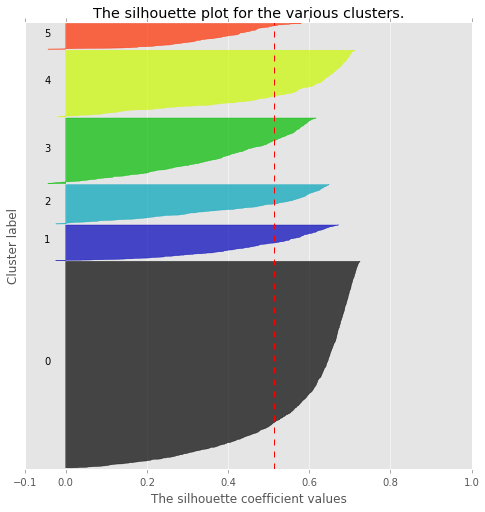

In [28]:
cluster_plot(fc_pca,6)

According to the results, all the Kmeans cluster showed high good cluster ratios. When the number of cluster for kmeans is six, it has 100% good cluster ratio, 3 employed, 3 unemployed. Moreover, it exhibited very high silhouette score. Thus, n_cluster will be set to 6.

In [29]:
km = KMeans(n_clusters=6)
km.fit(fc_pca)
fc_df['cluster'] = km.labels_

## Next step:

1. Pickle dfc[slct] and fc_df

2. Analyse average feature contribution in each cluster



In [30]:
with open('data/df.pkl','w') as f:
    pickle.dump(dfc[slct],f)

with open('data/fc_df.pkl','w') as f:
    pickle.dump(fc_df,f)